In [1]:
#1 Import packages
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from helper.time_series_helper import WindowGenerator

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False   # Turn off the grid

In [2]:
#Import data
path = "cases_malaysia_covid_FULL.csv"
df = pd.read_csv(path)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     780 non-null    object 
 1   cases_new                779 non-null    object 
 2   cases_import             780 non-null    int64  
 3   cases_recovered          780 non-null    int64  
 4   cases_active             780 non-null    int64  
 5   cases_cluster            780 non-null    int64  
 6   cases_unvax              780 non-null    int64  
 7   cases_pvax               780 non-null    int64  
 8   cases_fvax               780 non-null    int64  
 9   cases_boost              780 non-null    int64  
 10  cases_child              780 non-null    int64  
 11  cases_adolescent         780 non-null    int64  
 12  cases_adult              780 non-null    int64  
 13  cases_elderly            780 non-null    int64  
 14  cases_0_4                7

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,25/1/2020,4,4,0,4,0,4,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29/1/2020,3,3,0,7,0,3,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Data inspection
print("Number of NA: ", df.isna().sum())
print("Number of duplicates: ",df.duplicated().sum())
df.info()

Number of NA:  date                         0
cases_new                    1
cases_import                 0
cases_recovered              0
cases_active                 0
cases_cluster                0
cases_unvax                  0
cases_pvax                   0
cases_fvax                   0
cases_boost                  0
cases_child                  0
cases_adolescent             0
cases_adult                  0
cases_elderly                0
cases_0_4                    0
cases_5_11                   0
cases_12_17                  0
cases_18_29                  0
cases_30_39                  0
cases_40_49                  0
cases_50_59                  0
cases_60_69                  0
cases_70_79                  0
cases_80                     0
cluster_import             342
cluster_religious          342
cluster_community          342
cluster_highRisk           342
cluster_education          342
cluster_detentionCentre    342
cluster_workplace          342
dtype: int64
Number of d

In [4]:
#Isolate out Date column for train_df
date = pd.to_datetime(df.pop("date"),format="%d/%m/%Y")
date.head()



0   2020-01-25
1   2020-01-26
2   2020-01-27
3   2020-01-28
4   2020-01-29
Name: date, dtype: datetime64[ns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                779 non-null    object 
 1   cases_import             780 non-null    int64  
 2   cases_recovered          780 non-null    int64  
 3   cases_active             780 non-null    int64  
 4   cases_cluster            780 non-null    int64  
 5   cases_unvax              780 non-null    int64  
 6   cases_pvax               780 non-null    int64  
 7   cases_fvax               780 non-null    int64  
 8   cases_boost              780 non-null    int64  
 9   cases_child              780 non-null    int64  
 10  cases_adolescent         780 non-null    int64  
 11  cases_adult              780 non-null    int64  
 12  cases_elderly            780 non-null    int64  
 13  cases_0_4                780 non-null    int64  
 14  cases_5_11               7

In [6]:
#Describe data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cases_import,780.0,36.506410,91.179498,0.0,3.00,7.0,17.00,608.0
cases_recovered,780.0,4490.717949,6476.225456,0.0,64.75,1884.0,5422.50,33872.0
cases_active,780.0,55257.164103,77917.955395,1.0,1418.75,21990.0,66035.00,323618.0
cases_cluster,780.0,666.317949,787.821113,0.0,36.75,376.0,995.25,3394.0
cases_unvax,780.0,2405.275641,3044.223371,0.0,76.50,1211.0,3631.00,12684.0
cases_pvax,780.0,522.898718,1439.910614,0.0,0.00,0.0,122.50,7313.0
cases_fvax,780.0,1435.550000,2661.340076,0.0,0.00,0.0,2223.00,13079.0
cases_boost,780.0,566.533333,2500.686998,0.0,0.00,0.0,0.00,18123.0
cases_child,780.0,656.387179,987.153972,0.0,3.00,157.5,829.25,4389.0
cases_adolescent,780.0,321.387179,491.081120,0.0,3.00,88.0,373.00,2177.0


In [7]:
#Data cleaning
#Change "cases_new" from object to float
df['cases_new'] = pd.to_numeric(df['cases_new'],errors='coerce') 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                767 non-null    float64
 1   cases_import             780 non-null    int64  
 2   cases_recovered          780 non-null    int64  
 3   cases_active             780 non-null    int64  
 4   cases_cluster            780 non-null    int64  
 5   cases_unvax              780 non-null    int64  
 6   cases_pvax               780 non-null    int64  
 7   cases_fvax               780 non-null    int64  
 8   cases_boost              780 non-null    int64  
 9   cases_child              780 non-null    int64  
 10  cases_adolescent         780 non-null    int64  
 11  cases_adult              780 non-null    int64  
 12  cases_elderly            780 non-null    int64  
 13  cases_0_4                780 non-null    int64  
 14  cases_5_11               7

In [8]:
#fill na values using Interpolation method
df['cases_new'] = df['cases_new'].interpolate() 
df['cases_new'] = df['cases_new'].astype('int64')  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                780 non-null    int64  
 1   cases_import             780 non-null    int64  
 2   cases_recovered          780 non-null    int64  
 3   cases_active             780 non-null    int64  
 4   cases_cluster            780 non-null    int64  
 5   cases_unvax              780 non-null    int64  
 6   cases_pvax               780 non-null    int64  
 7   cases_fvax               780 non-null    int64  
 8   cases_boost              780 non-null    int64  
 9   cases_child              780 non-null    int64  
 10  cases_adolescent         780 non-null    int64  
 11  cases_adult              780 non-null    int64  
 12  cases_elderly            780 non-null    int64  
 13  cases_0_4                780 non-null    int64  
 14  cases_5_11               7

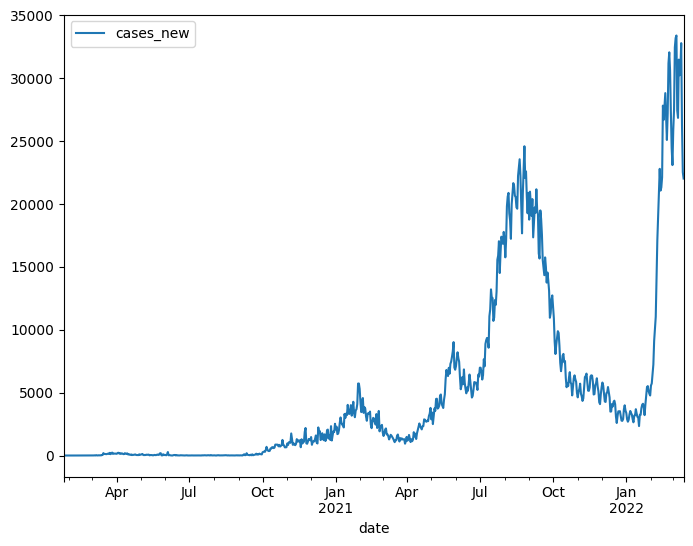

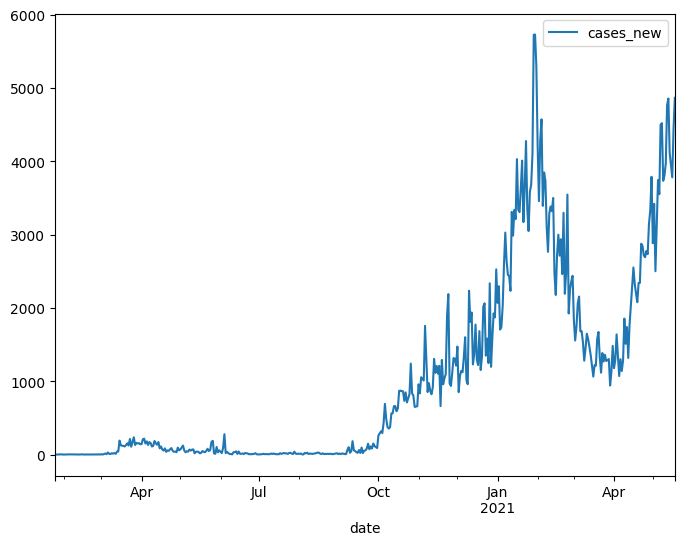

In [9]:
# Graph of cases_new over time(date)
plot_cols = ['cases_new']
plot_features = df[plot_cols]
plot_features.index = date
_ = plot_features.plot(subplots=True)
plt.show()

plot_features = df[plot_cols][:480]
plot_features.index = date[:480]
_ = plot_features.plot(subplots=True)
plt.show()

In [10]:
# Data Split
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df = df[plot_cols]
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]



In [11]:
#Data normalization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

C:\Users\youth\AppData\Local\Temp\ipykernel_15788\2995742042.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


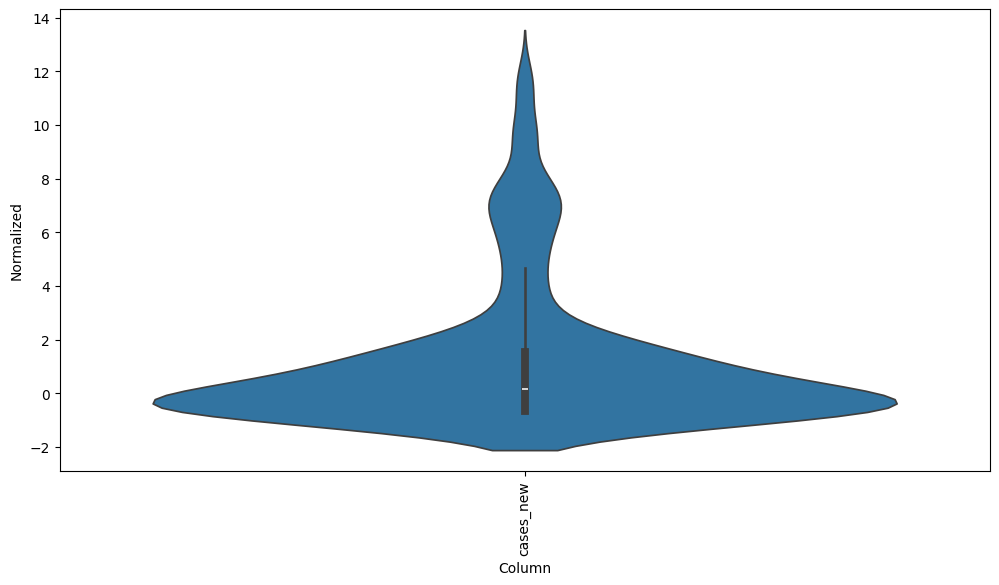

In [12]:
# Perform a violin plot to look at the distribution of the features
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [13]:
#Single-step window
single_window = WindowGenerator(input_width = 30,label_width=30,shift=1,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=["cases_new"],batch_size=128)
print(single_window)

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['cases_new']


In [14]:
# Multi-step window
OUT_STEPS = 30
multi_window =  WindowGenerator(input_width = 30,label_width=OUT_STEPS,shift=30,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=["cases_new"],batch_size=128)
print(multi_window)

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): ['cases_new']


In [15]:
#Create a single step model

lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(64,return_sequences=True))
lstm_model.add(tf.keras.layers.Dense(1))

In [16]:
#Define a function to compile and train the model
MAX_EPOCHS = 20
logpath = os.path.join(os.getcwd(), 'tensorboard_log', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = tf.keras.callbacks.TensorBoard(logpath)

def compile_and_fit(model, window, epochs=MAX_EPOCHS, patience=8):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, tb])
  return history

In [17]:
#Train model
history_single = compile_and_fit(lstm_model,single_window,epochs=50)

Epoch 1/20
5/5 [==============================] - 3s 122ms/step - loss: 0.7166 - mean_absolute_error: 0.6637 - val_loss: 17.3501 - val_mean_absolute_error: 3.3424
Epoch 2/20
5/5 [==============================] - 0s 35ms/step - loss: 0.4554 - mean_absolute_error: 0.5163 - val_loss: 13.4171 - val_mean_absolute_error: 2.7956
Epoch 3/20
5/5 [==============================] - 0s 28ms/step - loss: 0.2493 - mean_absolute_error: 0.3610 - val_loss: 10.1727 - val_mean_absolute_error: 2.2580
Epoch 4/20
5/5 [==============================] - 0s 31ms/step - loss: 0.1380 - mean_absolute_error: 0.2419 - val_loss: 8.2334 - val_mean_absolute_error: 2.1293
Epoch 5/20
5/5 [==============================] - 0s 28ms/step - loss: 0.1307 - mean_absolute_error: 0.2452 - val_loss: 7.7951 - val_mean_absolute_error: 2.0384
Epoch 6/20
5/5 [==============================] - 0s 26ms/step - loss: 0.1091 - mean_absolute_error: 0.2188 - val_loss: 7.8864 - val_mean_absolute_error: 1.9637
Epoch 7/20
5/5 [==============

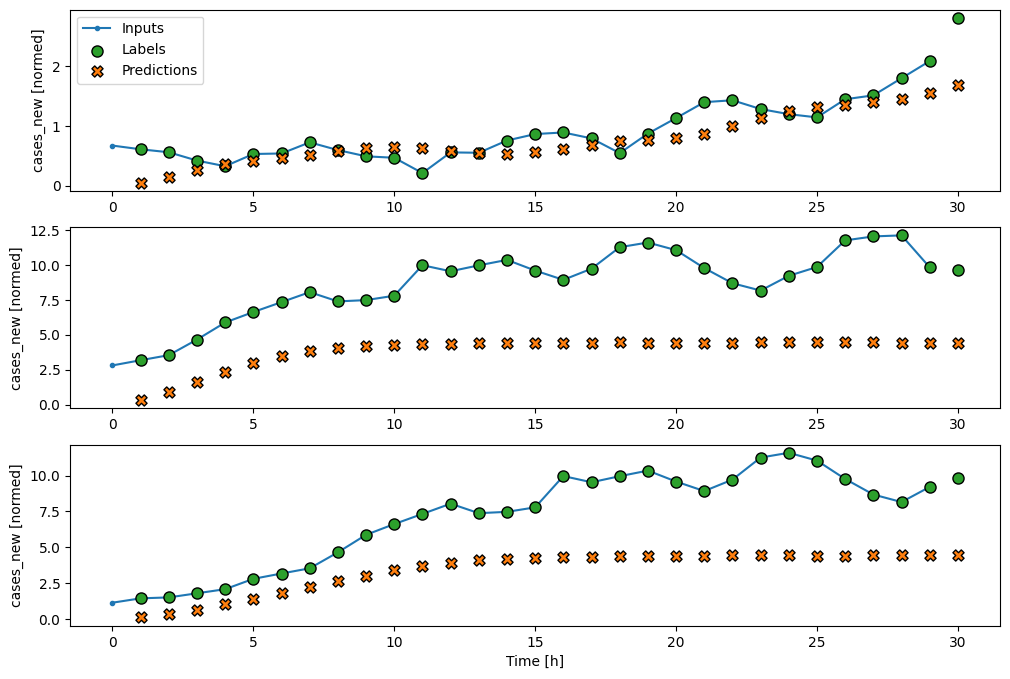

In [18]:
#Model Evaluation
single_window.plot(lstm_model, plot_col='cases_new')

In [19]:
#Multi Step LSM
multi_model = tf.keras.Sequential()
multi_model.add(tf.keras.layers.LSTM(64,return_sequences=True))
multi_model.add(tf.keras.layers.Dropout(0.2))
multi_model.add(tf.keras.layers.LSTM(64,return_sequences=False))
multi_model.add(tf.keras.layers.Dropout(0.2))
multi_model.add(tf.keras.layers.Dense(30))
multi_model.add(tf.keras.layers.Dense(30*1))
multi_model.add(tf.keras.layers.Reshape([30,1]))

In [20]:
history_multi = compile_and_fit(multi_model,multi_window,epochs=20)

Epoch 1/20
4/4 [==============================] - 4s 357ms/step - loss: 0.6904 - mean_absolute_error: 0.6445 - val_loss: 9.8305 - val_mean_absolute_error: 2.4995
Epoch 2/20
4/4 [==============================] - 0s 68ms/step - loss: 0.6346 - mean_absolute_error: 0.6095 - val_loss: 9.0657 - val_mean_absolute_error: 2.3176
Epoch 3/20
4/4 [==============================] - 0s 69ms/step - loss: 0.5614 - mean_absolute_error: 0.5550 - val_loss: 8.1161 - val_mean_absolute_error: 2.1066
Epoch 4/20
4/4 [==============================] - 0s 62ms/step - loss: 0.4965 - mean_absolute_error: 0.5053 - val_loss: 7.2950 - val_mean_absolute_error: 1.9480
Epoch 5/20
4/4 [==============================] - 0s 74ms/step - loss: 0.4316 - mean_absolute_error: 0.4608 - val_loss: 6.6512 - val_mean_absolute_error: 1.8206
Epoch 6/20
4/4 [==============================] - 0s 87ms/step - loss: 0.3727 - mean_absolute_error: 0.4197 - val_loss: 6.1172 - val_mean_absolute_error: 1.7110
Epoch 7/20
4/4 [=================

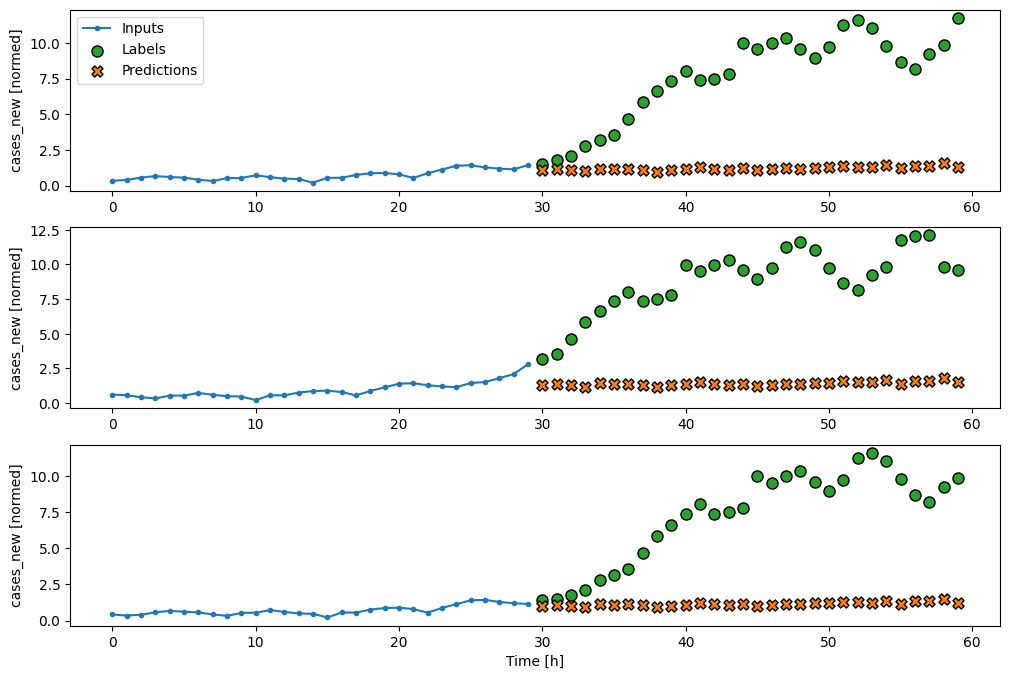

In [21]:
multi_window.plot(multi_model)

In [ ]:
#MAPE for single step and multi step model
def mape(model_name, model_history, true_values):
     sum_abs_values = np.sum(np.abs(true_values))
     mae = model_history.history['mean_absolute_error'][-1]     
     mape = (mae / sum_abs_values) * 100
     print(f"{model_name} MAPE value: {mape:.2f}%")
 
mape('Single-step Model', history_single, single_window.val_df['cases_new'])
mape('Multi-step Model', history_multi, multi_window.val_df['cases_new'])

Single-step Model MAPE value: 0.03%
Multi-step Model MAPE value: 0.04%
